### Notes



1. This notebook was entirely built and tested using Google Colab
2. Data 

   a. Part 1 - The data set blogtext.csv is provided with the assignment. Since the data is too large to be processed, we use only a subset of the data provided to train the models
   
   b. Part 2 - A .JSON file with the Q & A corpus has been provided. We have enhanced it by adding two more intents (Computer Vision, Natural Language Processing) and by adding more questions to existing intents
3. Running this notebook will require the user to involve in a conversation with the chat bot in Part 2 of the assignment
4. The user needs to mount the Google drive where training data set and chat bot corpus are stored

In [1]:
from google.colab import drive, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

import re, random, json

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, recall_score

import tensorflow as tf
!pip install tflearn
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 112kB 16.5MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=f262bf5053c6132281941cfa7f4aca62301557ec2415e2976921350c0891ab8c
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Part 1 - Digital Content Management

The objective of this part of the assignment is to create a classifier to predict different attributes of creators of content such as blogs and articles

The corpus consists a total of 681,288 posts 140 million+ words - approximately 35 posts and 7250 words per person

Load the data set. 

The data set is large and hence processing all records leads to memory issues. Hence we will read only the first 15000 rows and use them for training 

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Assignments/Statistical NLP/blogtext.csv"
blog_df = pd.read_csv(path,nrows=15000)

In [4]:
print("Shape of the data set is ",blog_df.shape)
blog_df.head(10)

Shape of the data set is  (15000, 7)


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


Each row has an Id, Gender (Male/Female), Age, Topic (profession), sign (Zodiac sign), date and text (blog/article content)

We need to predict gender, sign and topic for a given author after training the data set

In [5]:
blog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      15000 non-null  int64 
 1   gender  15000 non-null  object
 2   age     15000 non-null  int64 
 3   topic   15000 non-null  object
 4   sign    15000 non-null  object
 5   date    15000 non-null  object
 6   text    15000 non-null  object
dtypes: int64(2), object(5)
memory usage: 820.4+ KB


Check for missing values in the data set and if required, treat them

In [6]:
n_missingvalues=blog_df.isnull().values.sum()
if (n_missingvalues==0):
    print ("There are no missing values in the data")
else:
    print ("There are",n_missingvalues,"missing values in the data")

There are no missing values in the data


Check the 5-point summary of numberal attributes for the data set

In [7]:
blog_df.describe().loc[['min','25%','50%','mean','75%','max']].T

,min,25%,50%,mean,75%,max
id,23191.0,766556.0,1472026.0,1.971748e+06,3343504.0,4321739.0
age,13.0,23.0,26.0,2.670413e+01,35.0,47.0


Check the gender distribution. There are 8550 male (~57%) and 6450 female (~43%) authors in the data set

In [8]:
blog_df.gender.value_counts()

male      8550
female    6450
Name: gender, dtype: int64

Plot the number of male and female authors

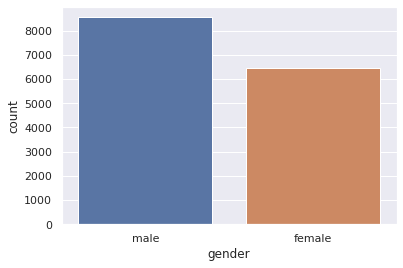

In [9]:
sns.countplot(x='gender',data=blog_df)

Plot the count of authors based on the Zodiac sign

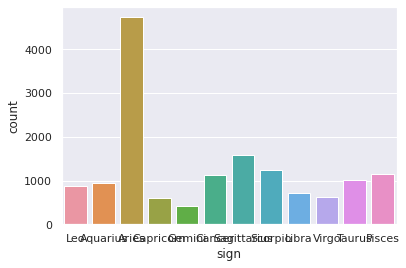

In [10]:
sns.countplot(x='sign',data=blog_df)

Almost all Zodiac signs have equal distribution except Gemini

Plot the count of authors by age

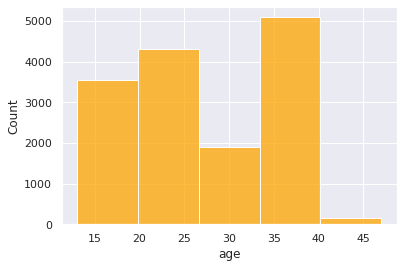

In [11]:
sns.histplot(data=blog_df,x='age',bins=5,color='orange')

Remove characters that are not alphanumeric using RegEx

In [12]:
pattern = "[^\w ]"
blog_df.text = blog_df.text.apply(lambda s : re.sub(pattern,"",s))

In [13]:
blog_df.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",Info has been found 100 pages and ...
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members Drewes...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoos Toolbar I can no...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow CocaCola has a way of sum...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",If anything Korea is a country of...
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


Convert all charcaters to lower case

In [14]:
blog_df.text = blog_df.text.apply(lambda s: s.lower())

In [15]:
blog_df.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info has been found 100 pages and ...
1,2059027,male,15,Student,Leo,"13,May,2004",these are the team members drewes...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoos toolbar i can no...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",i had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",somehow cocacola has a way of sum...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",if anything korea is a country of...
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",i surf the english news sites a l...


Remove leading and trailing spaces from the words

In [16]:
blog_df.text = blog_df.text.apply(lambda s: s.strip())

In [17]:
blog_df.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info has been found 100 pages and 45 mb of pd...
1,2059027,male,15,Student,Leo,"13,May,2004",these are the team members drewes van der la...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde maak je e...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoos toolbar i can now capture the...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",i had an interesting conversation with my dad ...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",somehow cocacola has a way of summing up thing...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",if anything korea is a country of extremes ev...
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",take a read of this news article from urllink ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",i surf the english news sites a lot looking fo...


Remove stopwords such as the, that etc. 

In [18]:
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))
blog_df.text = blog_df.text.apply(lambda t: ' '.join([words for words in t.split() if words not in stopwords]) )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
blog_df.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info found 100 pages 45 mb pdf files wait unti...
1,2059027,male,15,Student,Leo,"13,May,2004",team members drewes van der laag urllink mail ...
2,2059027,male,15,Student,Leo,"12,May,2004",het kader van kernfusie op aarde maak je eigen...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks yahoos toolbar capture urls popupswhich...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",interesting conversation dad morning talking k...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",somehow cocacola way summing things well early...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",anything korea country extremes everything see...
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",take read news article urllink joongang ilbo n...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",surf english news sites lot looking tidbits ko...


Remove the Id and Date features as they are not useful for training purposes

In [20]:
blog_df.drop(labels=['id','date'], axis=1,inplace=True)

In [21]:
blog_df.head(10)

,gender,age,topic,sign,text
0,male,15,Student,Leo,info found 100 pages 45 mb pdf files wait unti...
1,male,15,Student,Leo,team members drewes van der laag urllink mail ...
2,male,15,Student,Leo,het kader van kernfusie op aarde maak je eigen...
3,male,15,Student,Leo,testing testing
4,male,33,InvestmentBanking,Aquarius,thanks yahoos toolbar capture urls popupswhich...
5,male,33,InvestmentBanking,Aquarius,interesting conversation dad morning talking k...
6,male,33,InvestmentBanking,Aquarius,somehow cocacola way summing things well early...
7,male,33,InvestmentBanking,Aquarius,anything korea country extremes everything see...
8,male,33,InvestmentBanking,Aquarius,take read news article urllink joongang ilbo n...
9,male,33,InvestmentBanking,Aquarius,surf english news sites lot looking tidbits ko...


Let us merge all the label columns together i.e. gender, age, topic and Zodiac sign. Since this is the combination that we need to predict, it will act as a single label for the purpose of training

Once we have a single concatenated label, we can drop the individual labels which will not be required

In [22]:
blog_df['labels'] = blog_df.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)
blog_df.drop(columns=['gender','age','topic','sign'], axis=1, inplace=True)

In [23]:
blog_df.head(10)

,text,labels
0,info found 100 pages 45 mb pdf files wait unti...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoos toolbar capture urls popupswhich...,"[male, 33, InvestmentBanking, Aquarius]"
5,interesting conversation dad morning talking k...,"[male, 33, InvestmentBanking, Aquarius]"
6,somehow cocacola way summing things well early...,"[male, 33, InvestmentBanking, Aquarius]"
7,anything korea country extremes everything see...,"[male, 33, InvestmentBanking, Aquarius]"
8,take read news article urllink joongang ilbo n...,"[male, 33, InvestmentBanking, Aquarius]"
9,surf english news sites lot looking tidbits ko...,"[male, 33, InvestmentBanking, Aquarius]"


Separate the dependent (features) and independent (labels) variables form the data set. Split the data set into training and validation data sets using 80%-20% ratio

In [24]:
X= blog_df.text
y = blog_df.labels

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size = 0.2)

print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)

print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)


Shape of X_train: (12000,)
Shape of X_test: (3000,)
Shape of y_train: (12000,)
Shape of y_test: (3000,)


We will create a BOW (Bag of Words) using CountVectorizer and display the word count

In [25]:
countVectorizer = CountVectorizer(ngram_range=(1,2))
countVectorizer.fit(X_train)
len(countVectorizer.vocabulary_)

855318

Let us display the matrix of word token counts

In [26]:
countVectorizer.get_feature_names()

['00',
 '00 one',
 '00 tcr1',
 '000',
 '000 address',
 '000 calories',
 '000 people',
 '000 songs',
 '000 subject',
 '0000',
 '0000 blinking',
 '000001',
 '000001 maybe',
 '001',
 '001 first',
 '0015',
 '0015 15',
 '001875',
 '001875 plugging',
 '002',
 '002 first',
 '002 like',
 '002 middle',
 '003',
 '003 last',
 '004',
 '004 nicknames',
 '005',
 '005 euroes',
 '005 eurosnbsp',
 '005 gender',
 '005 pretty',
 '006',
 '006 age',
 '007',
 '007 birthday',
 '007 dun',
 '007 game',
 '007 undocumentables',
 '00734',
 '00734 wait',
 '008',
 '008 height',
 '009',
 '009 hair',
 '00s',
 '00s rest',
 '01',
 '01 101102',
 '01 informs',
 '01 known',
 '01 means',
 '01 minds',
 '01 role',
 '01 televive',
 '01 triggered',
 '01 underworld',
 '01 我的地盤',
 '010',
 '010 eye',
 '0100',
 '0100 hrs',
 '0100 wokeup',
 '0100010001101111011100100110101101111000',
 '010203',
 '010203 hehehe',
 '011',
 '011 race',
 '011 uich',
 '0117',
 '0117 4452271145527',
 '011785',
 '011785 45227',
 '012',
 '012 glasses',
 '0

Convert the feature values into a document-term matrix

In [27]:
X_train_Xform = countVectorizer.transform(X_train)
X_test_Xform = countVectorizer.transform(X_test)

In [28]:
#print("Type:",type(X_train_Xform))
X_train_Xform[0]

<1x855318 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [29]:
print('**********Training data**********')
print(X_train_Xform)
print('**********Test Data**********')
print(X_test_Xform)

**********Training data**********
  (0, 90002)	1
  (0, 90138)	1
  (0, 291045)	1
  (0, 291091)	1
  (0, 757213)	1
  (1, 497)	1
  (1, 690)	1
  (1, 1529)	1
  (1, 1611)	1
  (1, 18267)	1
  (1, 18649)	1
  (1, 22972)	1
  (1, 22992)	1
  (1, 35733)	1
  (1, 35850)	1
  (1, 36704)	1
  (1, 36733)	1
  (1, 49453)	3
  (1, 49461)	1
  (1, 50248)	1
  (1, 50575)	1
  (1, 58113)	1
  (1, 58193)	1
  (1, 62682)	2
  (1, 63188)	1
  :	:
  (11999, 539221)	1
  (11999, 552419)	1
  (11999, 552848)	1
  (11999, 620143)	1
  (11999, 620181)	1
  (11999, 622186)	1
  (11999, 622224)	1
  (11999, 624363)	1
  (11999, 624364)	1
  (11999, 656560)	1
  (11999, 656561)	1
  (11999, 678063)	1
  (11999, 678067)	1
  (11999, 696491)	1
  (11999, 696497)	1
  (11999, 714924)	1
  (11999, 714954)	1
  (11999, 747656)	1
  (11999, 748185)	1
  (11999, 771245)	1
  (11999, 771247)	1
  (11999, 831231)	1
  (11999, 831234)	1
  (11999, 845263)	1
  (11999, 845552)	1
**********Test Data**********
  (0, 16850)	1
  (0, 31890)	1
  (0, 45990)	1
  (0, 73963)	

Get the count of every label and store it in a dictionary. Print the dictionary of labels and corresponding counts

In [30]:
label_counts=dict()

for labels in blog_df.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

label_counts

{'13': 1,
 '14': 1,
 '15': 1,
 '16': 1,
 '17': 1,
 '23': 1,
 '24': 1,
 '25': 1,
 '26': 1,
 '27': 1,
 '33': 1,
 '34': 1,
 '35': 1,
 '36': 1,
 '37': 1,
 '38': 1,
 '39': 1,
 '40': 1,
 '41': 1,
 '42': 1,
 '43': 1,
 '44': 1,
 '45': 1,
 '46': 1,
 '47': 1,
 'Accounting': 35,
 'Advertising': 5,
 'Agriculture': 46,
 'Aquarius': 941,
 'Architecture': 45,
 'Aries': 4732,
 'Arts': 289,
 'Automotive': 14,
 'Banking': 61,
 'BusinessServices': 148,
 'Cancer': 1132,
 'Capricorn': 596,
 'Communications-Media': 99,
 'Consulting': 57,
 'Education': 609,
 'Engineering': 330,
 'Fashion': 1622,
 'Gemini': 412,
 'Government': 85,
 'HumanResources': 2,
 'Internet': 652,
 'InvestmentBanking': 70,
 'Law': 44,
 'LawEnforcement-Security': 46,
 'Leo': 880,
 'Libra': 705,
 'Marketing': 207,
 'Military': 19,
 'Museums-Libraries': 66,
 'Non-Profit': 150,
 'Pisces': 1147,
 'Publishing': 67,
 'Religion': 28,
 'Sagittarius': 1589,
 'Science': 78,
 'Scorpio': 1232,
 'Sports-Recreation': 80,
 'Student': 1680,
 'Taurus': 1

We will transform labels to a binary form using MultiLabelBinarizer. This converts the label to a set of 0s and 1s. 

In [31]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

We will use the One vs Rest approach implemented using OneVsRestClassifier. This trains a number of classifiers i.e number of tags. We use a simple LogisticRegression classifier for this task. We experimented with other classifiers such as KNN, SVC but Logistic Classifier performed the best among them

Note : This step takes about 15 minutes to run

In [32]:

model=LogisticRegression(solver='lbfgs', max_iter=1000)
#model = SVC(C=1, gamma='scale')
#model = KNeighborsClassifier(n_neighbors=3)
model=OneVsRestClassifier(model)
model.fit(X_train_Xform,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [33]:
Ypred=model.predict(X_test_Xform)
Ypred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [34]:
y_test

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 0]])

Let us display the classification report based on micro, macro and weighted averaging

In [35]:
def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

In Micro-average method, we sum up individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics.

In [36]:
display_metrics_micro(y_test,Ypred)

Accuracy score:  0.191
F1 score: Micro 0.5671771164403352
Average precision score: Micro 0.37737412399897136
Average recall score: Micro 0.43622222222222223


In the macro average Method, we consider the average of precision and recall of the system on different sets

In [37]:
display_metrics_macro(y_test,Ypred)

Accuracy score:  0.191
F1 score: Macro 0.14436921766671557
Average recall score: MAcro 0.1017775391039989


In [38]:
display_metrics_weighted(y_test,Ypred)

Accuracy score:  0.191
F1 score: weighted 0.5243528874758826
Average precision score: weighted 0.4712070021851925
Average recall score: weighted 0.43622222222222223


Print the actual and predicted labels for the first 15 entries from the dataset

In [39]:
preds = Ypred[:15]
actuals = y_test[:15]

five_actual = binarizer.inverse_transform(actuals)
five_actual

[('Capricorn', 'Internet', 'female'),
 ('Aries', 'Fashion', 'male'),
 ('Leo', 'Telecommunications', 'male'),
 ('Capricorn', 'Sports-Recreation', 'male'),
 ('Taurus', 'female', 'indUnk'),
 ('Aries', 'Fashion', 'male'),
 ('Aries', 'Technology', 'male'),
 ('Leo', 'Student', 'female'),
 ('Pisces', 'female', 'indUnk'),
 ('Aries', 'Technology', 'male'),
 ('Aquarius', 'Education', 'female'),
 ('Sagittarius', 'female', 'indUnk'),
 ('Government', 'Virgo', 'female'),
 ('Aries', 'Fashion', 'male'),
 ('Aries', 'Fashion', 'male')]

In [40]:
five_pred = binarizer.inverse_transform(preds)
five_pred

[('female',),
 ('male',),
 ('Aquarius', 'Banking', 'male'),
 ('male',),
 ('female', 'indUnk'),
 ('Aries', 'male'),
 ('male',),
 ('Student', 'female', 'indUnk'),
 ('Sagittarius', 'female', 'indUnk'),
 ('Aries', 'Technology', 'male'),
 ('Aries', 'male'),
 ('Fashion', 'Sagittarius', 'indUnk'),
 ('female', 'indUnk'),
 ('Aries', 'male'),
 ('male',)]

Print the true vs predicted labels for randomly chosen 10 entries from the dataset.

In [41]:
rand=[]
for i in range(10):
    rand.append(random.randint(1,len(Ypred)))
   
for i in rand:    
    print("Predicted:",binarizer.inverse_transform(Ypred)[i])
    print("Actual:",binarizer.inverse_transform(y_test)[i],'\n')

Predicted: ('male',)
Actual: ('Capricorn', 'Engineering', 'male') 

Predicted: ('female',)
Actual: ('Consulting', 'Pisces', 'female') 

Predicted: ('Education', 'Pisces', 'male')
Actual: ('Education', 'Pisces', 'male') 

Predicted: ('Aries', 'male')
Actual: ('Aries', 'Technology', 'male') 

Predicted: ('male',)
Actual: ('Taurus', 'female', 'indUnk') 

Predicted: ('female',)
Actual: ('Pisces', 'female', 'indUnk') 

Predicted: ('male',)
Actual: ('Aquarius', 'Engineering', 'male') 

Predicted: ('male',)
Actual: ('Taurus', 'female', 'indUnk') 

Predicted: ('male',)
Actual: ('Aries', 'Technology', 'male') 

Predicted: ('Aries', 'Fashion', 'male')
Actual: ('Aries', 'Fashion', 'male') 



It is observed that the actual and predicted values are the same in most of the cases. There are a few data points where the predictions are either not complete or accurate

## Conclusion

1. We loaded the provided data set and performed exploratory data analysis on the data
2. We considered a subset of the data and performed data pre-processing to make sentences lower case, remove stop words, remove unwanted characters etc. 
3. We vectorized the features using CountVectorizer to created  Bag of words
4. We created a dictionary to get the count of each label
5. Using OneVsRest approach and Logistic Regression Classifier, we trained the model 
6. We displayed the classification report using different metrics - micro, macro and weighted
7. We chose random data points from the validation set and compared the actual and predicted values

## Part 2 - Customer Support

The objective of this part of the assignment is to 

* Implement a text-based chatbot based that can provide Customer Support
* The chatbot should accept arbitrary questions from the customer and reply with relevant answers
* Provide continuous interaction until the customer opts to "Quit" the chat
* Enhance the corpus by adding more questions and answers

Load and displaty the enhanced corpus, which is a .JSON file

Note: The corpus provided was enhanced with more questions and responses

In [49]:
with open("/content/drive/MyDrive/Colab Notebooks/Assignments/Statistical NLP/GL Bot.json") as file:
  Corpus = json.load(file)

print(Corpus)

{'intents': [{'tag': 'Intro', 'patterns': ['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'hola', 'hiya', 'hows it going', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'talking to you for first time'], 'responses': ['Hello! how can i help you ?'], 'context_set': ''}, {'tag': 'Exit', 'patterns': ['thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'i am leaving', 'no more questions', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy'], 'responses': ["I am happy to be able to assist you. {Enter 'quit' to end}"], 'context_set': ''}, {'tag': 'Olympus', 'patterns': ['olympus', 'explain me how olympus works', 'I am not able to understand olympus', 'olympus window not working', 'no access to olympus', 'unable to see link in olympus',

Tokenize the corpus using "punkt" Sentence Tokenizer 

In [50]:
#Download the tokenizer
nltk.download('punkt')


W = []
L = []
doc_x = []
doc_y = []

#Loop through the Corpus and tokenize all sentences (patterns)
for intent in Corpus['intents']:
  for pattern in intent['patterns']:
    w_temp = nltk.word_tokenize(pattern)
    W.extend(w_temp)
    doc_x.append(w_temp)
    doc_y.append(intent['tag'])
  
  # Collect all intents
  if intent['tag'] not in L:
    L.append(intent['tag'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Perform stemming to reduce the bag of words to their root words. In this case, we decided to use PorterStemmer

In [51]:
stemmer = PorterStemmer()

W = [stemmer.stem(w.lower()) for w in W if w!='?']
W = sorted(list(set(W)))
L = sorted(L)

Generate a bag of words

Perform one-hot encoding of the targets (tags) 

In [52]:
Train = []
Target = []

out_empty = [0 for _ in range(len(L))]

for x,doc in enumerate(doc_x):
  bag=[]

  w_temp = [stemmer.stem(w.lower()) for w in doc]

  # One hot vector encoding
  for w in W:
    if w in w_temp:
      bag.append(1)
    else:
      bag.append(0)

  output_row = out_empty[:]
  output_row[L.index(doc_y[x])] = 1

  # Construct the training bag of words
  Train.append(bag)

  #Construct the targets
  Target.append(output_row) 

We have used a Fully Connected Neural network to train the Corpus against the Target tags. The classifier model thus trained will be used by the chatbot to predict the target tag of a given question

In [53]:
# Build the FCNN using Dense layers and 1 dropout layer
# "Relu" as the activation function for the hidden layers
# "Softmax" as the activation for output layer as it is a multi-class classification
model=Sequential()

model.add(Dense(128,input_dim=len(Train[0]),activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16,activation='relu'))

# We used 10 neurons in the output layer corresponding to the 10 tags that need to be predicted
model.add(Dense(10,activation='softmax'))

# Complile and fit the model
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(Train,Target,epochs=100,batch_size=32)

Epoch 1/100
8/8 [==============================] - 1s 3ms/step - loss: 2.2880
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2488
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1985
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1287
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0786
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0183
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 1.9670
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9314
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7981
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 1.7638
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6207
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5314
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

In [54]:
def bag_of_words(s,W):
  bag = [0 for _ in range(len(W))]

  s_words = nltk.word_tokenize(s)
  s_words = [stemmer.stem(word.lower()) for word in s_words]

  for se in s_words:
    for i,w in enumerate(W):
      if w == se:
        bag[i] = 1
  
  return np.array(bag)

Here, we have implemented the chat interface, which engages in a conversation with the customer until he/she types "quit"

In [55]:
def chat():
  print("Chat with GLBOT (Type quit to end conversation)")
  print("if answer is not right (type:*)")
  while True:
    inp=input("\n\nYou:")
    if (inp.lower()=='*'):
      print("GLBOT:Please rephrase your question and try again")
    if (inp.lower()=='quit'):
      break

    bow = [bag_of_words(inp,W)]
    bow = np.array(bow)
    results = model.predict(bow)
    
    results_index = np.argmax(results)
    tag = L[results_index]

    for tg in Corpus['intents']:
      if tg['tag'] == tag:
        responses = tg['responses']
    
    print(random.choice(responses))

Start the conversation

In [56]:
chat()

Chat with GLBOT (Type quit to end conversation)
if answer is not right (type:*)


You:hello
Hello! how can i help you ?


You:who are you
I am GLBOT, your virtual learning assistant. Please ask me anything


You:can you introduce ?
I am GLBOT, your virtual learning assistant. Please ask me anything


You:your name
I am GLBOT, your virtual learning assistant. Please ask me anything


You:what is artificial intelligence
Please refer to the Neural Nets wiki


You:what is supervised learning
Please refer to the Machine Learning wiki


You:fully connected network
Please refer to the Neural Nets wiki


You:help me with bert
Please refer to the Natural Language Processing wiki


You:what is image
Please refer to the Computer Vision wiki


You:how is image processed
Please refer to the Computer Vision wiki


You:what is knn
Please refer to the Machine Learning wiki


You:what is k nearest neighbors
Please refer to the Natural Language Processing wiki


You:hw are u 
Please refer to the Neural 

## Conclusion

1. We loaded the provided corpus in the .JSON format containing the intents, questions and responses

2. We performed data pre-processing by tokenizing and stemming

3. We generated a BOW and generated word vector embeddings

4. We built and trained a Fully Connected Neural Network on the corpus w.r.t the target variable

5. We designed a simple conversational UI that accepts questions from the user and used the trained NN to predict the answers